In [221]:
import calendar
import csv
from datetime import datetime, timedelta
import itertools
import os
import pprint

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
#import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d, UnivariateSpline

plt.rcParams.update({'font.size': 8})


In [222]:
et_cell_path = 'et_cell_metadata.csv'
# et_cell_path = os.path.join(os.getcwd(), 'et_cell_metadata.csv')

kc_ws = os.path.join(os.getcwd(), 'kc')
eto_ws = os.path.join(os.getcwd(), 'eto')
etf_ws = os.path.join(os.getcwd(), 'etf')

eto_file_prefix = 'eto'
etf_file_prefix = 'etf'

interp_days = 32


# Skipping the wine grapes for now
crop_types = {
    3: 'Alfalfa Hay',
    4: 'Grass Hay',
    7: 'Field Corn',
    13: 'Winter Grain',
    16: 'Grass Pasture',
    19: 'Apples and Cherries',
    # 25: 'Grapes, Wine',
    42: 'Blue Grass Seed',
}
crops = [3, 4, 7, 13, 16, 19, 25, 42]


# Don't include 1999 or 2013 because they only have partial 2 Landsat coverage
# Don't include 2022 or 2023 for now since the Kc data ends Dec 2022
# Not sure if 2012 is really needed in the one Landsat list, but including it to get the SLC-off scenes
# For the two Landsat list, started with the even years then added a few to match the one Landsat count
one_landsat_years = [1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 2012]
two_landsat_years = [2000, 2001, 2002, 2004, 2005, 2006, 2008, 2009, 2010, 2014, 2015, 2016, 2018, 2019, 2020]
landsat_years = one_landsat_years + two_landsat_years
print(one_landsat_years)
print(two_landsat_years)


summer_months = [6, 7, 8]
growsn_months = [4, 5, 6, 7, 8, 9, 10]


[1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 2012]
[2000, 2001, 2002, 2004, 2005, 2006, 2008, 2009, 2010, 2014, 2015, 2016, 2018, 2019, 2020]


### Read ET cell metadata file

In [223]:
print('')
et_cell_df = pd.read_csv(et_cell_path)
print(f'  ET cell count: {len(et_cell_df)}')
print(et_cell_df)


  ET cell count: 11
    GRIDMET_ID        LAT         LON     ELEV_M   ELEV_FT  FIPS_C STPO  \
0       387098  36.691661 -107.933323  1701.0400  5580.840   35045   NM   
1       467476  39.108327 -108.349989  1513.2000  4964.570    8077   CO   
2       473008  39.274994 -108.849989  1426.9200  4681.500    8077   CO   
3       511799  40.441660 -109.558322  1679.2400  5509.320   49047   UT   
4       581084  42.524994 -110.183322  2130.3600  6989.370   56035   WY   
5       605776  43.275000 -120.850000  1314.7200  4313.390   41037   OR   
6       661167  44.941667 -122.891667    69.1667   226.925   41047   OR   
7       686149  45.691667 -121.475000   231.8400   760.630   41027   OR   
8       688961  45.775000 -119.808333   179.2000   587.927   41049   OR   
9       564161  42.024995 -122.308319  1116.6000  3663.390   41029   OR   
10      565566  42.066661 -121.516653  1370.3600  4495.930   41035   OR   

    COUNTYNAME CNTYCATEGO   STATENAME      HUC8  
0     San Juan     County  N

## Show ET cell locations

In [224]:
import ee
# Change this to reflect your GEE account project name
project_name = 'ee-revellegee'

ee.Initialize(project=project_name)

In [225]:

import geemap

points_coll = ee.FeatureCollection([
    ee.Feature(ee.Geometry.Point(et_cell['LON'], et_cell['LAT']), {'cell_id': et_cell['GRIDMET_ID']})
    for index, et_cell in et_cell_df.iterrows()
])

huc_coll = ee.FeatureCollection('USGS/WBD/2017/HUC08')
#     .filterBounds(points_coll.geometry().bounds())

Map = geemap.Map()
#Map.add_basemap("Esri.WorldImagery")
#Map.add_basemap("OpenTopoMap")
Map.addLayer(huc_coll, {'color': 'blue'}, 'HUC8', True, 0.25)
Map.addLayer(points_coll, {'color': 'red'}, 'ET Cell Centroids')
Map.centerObject(points_coll, 5)
Map


Map(center=[42.15729924288711, -115.57796444349339], controls=(WidgetControl(options=['position', 'transparent…

## Build the list of ET cells and crops to process

In [226]:
et_cell_crops = []

for cell_id, et_cell in et_cell_df.iterrows():
    for crop_num, crop_name in crop_types.items():
        kc_path = os.path.join(kc_ws, f'{et_cell["GRIDMET_ID"]}_crop_{crop_num:02d}.csv')
        if not os.path.isfile(kc_path):
            continue
        et_cell_crops.append([et_cell, kc_path])

# pprint.pprint(et_cell_crops)
for et_cell, kc_path in et_cell_crops:
    print(kc_path.split('/')[-1])


387098_crop_03.csv
387098_crop_04.csv
387098_crop_16.csv
467476_crop_03.csv
467476_crop_04.csv
467476_crop_16.csv
467476_crop_19.csv
473008_crop_03.csv
473008_crop_04.csv
473008_crop_07.csv
473008_crop_13.csv
473008_crop_16.csv
511799_crop_03.csv
511799_crop_04.csv
511799_crop_07.csv
511799_crop_16.csv
581084_crop_04.csv
605776_crop_03.csv
661167_crop_42.csv
686149_crop_19.csv
688961_crop_03.csv
564161_crop_04.csv
565566_crop_03.csv


In [370]:
# Interpolation method to use (either "linear" or "spline")
interp_method = 'spline'

## Functions

In [371]:
def read_daily_eto(file_path, year):
    """Read in the daily ETo"""
    daily_eto_df = pd.read_csv(file_path)
    daily_eto_df.set_index('date', inplace=True)
    daily_eto_df.index = pd.to_datetime(daily_eto_df.index, format='%Y-%m-%d')
    
    return daily_eto_df


def read_landsat_scene_etf(file_path, year):
    """Read in the Landsat scene ETf dataframe to get the Landsat observation dates"""
    scene_etf_df = pd.read_csv(file_path)
    scene_etf_df.set_index('date', inplace=True)
    scene_etf_df.index = pd.to_datetime(scene_etf_df.index, format='%Y-%m-%d')

    # Clamping would be needed if the ETf data was being used and not filled with the Kc
    # scene_etf_df['etf'] = scene_etf_df['etf'].clip(0, 1.4)
    
    return scene_etf_df
   

def interpolate_daily_etf(scene_etf_df, cell_id, year, interp_days=32, method='linear'):
    """Interpolate daily ETf values using either linear or spline interpolation"""
    
    # Build the daily dataframe with missing values that need to be interpolated
    interp_daily_etf_df = (
        scene_etf_df.drop(columns=['landsat'])
        .reindex(pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31', freq='D'), method=None)
    )
    
    interp_daily_etf_df['month'] = interp_daily_etf_df.index.month
    
    # Convert dates to ordinal numbers for interpolation
    x = scene_etf_df.index.map(datetime.toordinal)
    y = scene_etf_df['etf'].values
    
    # Find the max ETf for the timeseries to limit the spline overshooting values
    yearly_max = scene_etf_df['etf'].max()
    
    if method == 'spline':
        # Create spline interpolation function
        f = UnivariateSpline(x, y, k=3, s=0)  # Increase s for more smoothing
    
    # Interpolate the missing daily values
    for date in pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31', freq='D'):
        # Assume that on days with values we don't need to interpolate anything
        if not scene_etf_df[scene_etf_df.index == date].empty:
            continue
            
        prev_df = scene_etf_df[(scene_etf_df.index >= (date - timedelta(days=interp_days))) & (scene_etf_df.index < date)]
        next_df = scene_etf_df[(scene_etf_df.index > date) & (scene_etf_df.index <= (date + timedelta(days=interp_days)))]
    
        if next_df.empty and prev_df.empty:
            # No data before or after the target date
            pass
        elif next_df.empty and not prev_df.empty:
            # No data after the target date, so use the closest previous value
            interp_daily_etf_df.at[date, 'etf'] = prev_df.iloc[-1]['etf']
        elif prev_df.empty and not next_df.empty:
            # No data before the target date, so use the closest next value
            interp_daily_etf_df.at[date, 'etf'] = next_df.iloc[0]['etf']
        else:
            # Data before and after target date, use specified interpolation method
            if method == 'linear':
                time_ratio = (date - prev_df.index[-1]).days / (next_df.index[0] - prev_df.index[-1]).days
                interp_value = (next_df.iloc[0]['etf'] - prev_df.iloc[-1]['etf']) * time_ratio + prev_df.iloc[-1]['etf']
            elif method == 'spline':
                interp_value = f(date.toordinal())
            else:
                raise ValueError("Invalid interpolation method. Use 'linear' or 'spline'.")
            
            interp_daily_etf_df.at[date, 'etf'] = np.clip(interp_value, 0, yearly_max)

    return interp_daily_etf_df


def compute_monthly_scene_counts(scene_etf_df, year):
    """Compute the scene counts per month"""
    
    scene_counts_df = scene_etf_df.groupby([scene_etf_df.index.to_period('M')]).agg(scene_count=('etf', 'count'))
    scene_counts_df.index = scene_counts_df.index.astype('datetime64[ns]')
    
    # Is there a way to fill with 0's when you reindex (instead of the manual approach here)?
    scene_counts_df = scene_counts_df.reindex(pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31', freq='MS'), method=None)
    scene_counts_df[scene_counts_df['scene_count'].isnull()] = 0
    scene_counts_df['scene_count'] = scene_counts_df['scene_count'].astype(int)
    
    # Set the month as the index for joining
    scene_counts_df['month'] = scene_counts_df.index.month
    scene_counts_df.set_index('month', inplace=True)
    
    return scene_counts_df


def compute_interpolated_monthly_et(interp_daily_etf_df):
    """"""
    
    # Join the interpolated ETf to the daily ETo
    interp_daily_df = daily_eto_df.join(interp_daily_etf_df, how='inner')
    
    # Compute daily ET
    interp_daily_df['et'] = interp_daily_df['eto'] * interp_daily_df['etf']
    
    # Compute monthly aggregations
    interp_month_df = (
        interp_daily_df.groupby([interp_daily_df.index.to_period('M')])
        .agg(et_interp=('et', 'sum'))
    )
    interp_month_df['month'] = interp_month_df.index.month
    interp_month_df.set_index('month', inplace=True)

    return interp_month_df


def compute_interpolated_daily_counts(interp_daily_etf_df):
    # TODO: We probably don't need to compute ET here and could just use ETf
    
    # Join the interpolated ETf to the daily ETo
    interp_daily_df = daily_eto_df.join(interp_daily_etf_df, how='inner')
    
    # Compute daily ET
    interp_daily_df['et'] = interp_daily_df['eto'] * interp_daily_df['etf']
    
    # Compute the daily image counts for each month
    daily_counts_df = (
        interp_daily_df.groupby([interp_daily_df.index.to_period('M')])
        .agg(daily_count=('et', 'count'))
    )
    daily_counts_df['month'] = daily_counts_df.index.month
    daily_counts_df.set_index('month', inplace=True)
    
    return daily_counts_df


def read_target_daily_kc(kc_path, year):
    """Get the target Kc curve"""
    
    # The first line of the file is the crop type
    #   or we might want to get it from the file name
    # kc_crop_num = int(kc_path.split('_')[-1])
    with open(kc_path) as f:
        kc_crop = f.readline()
    kc_crop_num = int(kc_crop.split('-')[0].replace('#', '').strip())
    kc_crop_name = kc_crop.split('-')[-1].strip()
    
    # Read in the full Kc time series
    kc_df = pd.read_csv(kc_path, skiprows=1)
    kc_df.set_index('Date', inplace=True, drop=True)
    kc_df.index = pd.to_datetime(kc_df.index, format='%Y-%m-%d')

    # Then filter to the target year    
    target_daily_kc_df = kc_df.loc[
        (kc_df.index >= datetime(year-1, 11, 1)) & (kc_df.index < datetime(year+1, 3, 1)), 
        ['Kc', 'Kcb']
    ]
    target_daily_kc_df.rename(columns={"Kc": "kc", "Kcb": "kcb"}, inplace=True)
    # target_daily_kc_df.set_index('Date', inplace=True)
    # target_daily_kc_df.index = pd.to_datetime(target_daily_kc_df.index, format='%Y-%m-%d')
    
    return target_daily_kc_df


def compute_target_month_et(target_daily_kc_df, daily_eto_df, cell_id, year):
    """Compute the target daily ET"""
    
    # Filter to the target year since the extra months are needed for interpolation
    target_daily_df = daily_eto_df.join(target_daily_kc_df, how='inner')
    target_daily_df['et'] = target_daily_df['eto'] * target_daily_df['kc']
    # print(target_daily_df)
    
    # Compute the monthly aggregations for the target data
    target_month_df = target_daily_df.groupby([target_daily_df.index.to_period('M')])\
        .agg(et_target=('et', 'sum'), eto_target=('eto', 'sum'))
    target_month_df['eto_year'] = year
    
    # Convert index back to datetimes with the day
    # target_month_df.index = target_month_df.index.astype('datetime64[ns]')
    
    # Use the month as the index
    target_month_df['month'] = target_month_df.index.month
    target_month_df.set_index('month', inplace=True)

    return target_month_df


def compute_days_in_month(year):
    return pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31', freq='MS').days_in_month


## Compute the dataframes for each ET cell, crop, and year

In [372]:
monthly_list = []
summer_list = []
growsn_list = []
annual_list = []
all_interp_values = []
all_scene_values = []
all_kc_values = []

kc_fill = 'kc'
# kc_fill = 'kcb'


# Iterate through the ET cell and crop combinations
for et_cell, kc_path in et_cell_crops:
    
    cell_id = et_cell['GRIDMET_ID']
    
    # TODO: Switch to a regex to get the crop number out of the Kc file path
    crop_num = int(kc_path.replace('.csv', '').split('_')[-1])
    crop_name = crop_types[crop_num]
    
    print(f'ET Cell {cell_id} - Crop {crop_num} - {crop_name}')
    print(f'  {kc_path}')

    # For now compute ETo and ETf as a pair
    # If we need additional data points we could pair different Landsat and ETo years also
    for scene_year, eto_year in [[year, year] for year in landsat_years]:
        # print(f'    Landsat Year: {scene_year},  ETo Year: {eto_year}')

        eto_path = os.path.join(
            eto_ws, f'{eto_year}', f'{eto_file_prefix}_{eto_year}_{cell_id}.csv'
        )
        etf_path = os.path.join(
            etf_ws, f'{scene_year}', f'{etf_file_prefix}_{scene_year}_{cell_id}.csv'
        )

        scene_etf_df = read_landsat_scene_etf(etf_path, year=scene_year)
        #print(scene_etf_df)
    
        target_daily_kc_df = read_target_daily_kc(kc_path, year=eto_year)
        #print(target_daily_kc_df)
        #fig, ax0 = plt.subplots(1, 1, figsize=(6, 3), dpi=150)
        #target_daily_kc_df['kc'].plot(ax=ax0, color='gray', lw=0.5)
        #target_daily_kc_df['kcb'].plot(ax=ax0, color='blue', lw=0.5)

        # Fill scene ETf values with the Kc curve values
        # TODO: Make this into a separate function once the Kc tables are built
        scene_etf_df = scene_etf_df.join(target_daily_kc_df, how='inner')
        scene_etf_df['etf'] = scene_etf_df[kc_fill]
        scene_etf_df.drop(['kc'], axis=1, inplace=True)
        scene_etf_df.drop(['kcb'], axis=1, inplace=True)
        
        interp_daily_etf_df = interpolate_daily_etf(
            scene_etf_df, cell_id=cell_id, year=scene_year, interp_days=interp_days, method=interp_method
        )
        # fig, ax0 = plt.subplots(1, 1, figsize=(6, 3), dpi=150)
        # interp_daily_etf_df['etf'].plot(ax=ax0, linestyle='none', marker='.', ms=1, color='blue')
        # scene_etf_df['etf'].plot(ax=ax0, linestyle='none', marker='^', ms=3, color='red')
        
        scene_counts_df = compute_monthly_scene_counts(scene_etf_df, year=scene_year)
        #print(scene_counts_df)
        
        daily_eto_df = read_daily_eto(eto_path, year=eto_year)
        #print(daily_eto_df)
        
        interp_month_df = compute_interpolated_monthly_et(interp_daily_etf_df)
        #print(interp_month_df)
        
        daily_counts_df = compute_interpolated_daily_counts(interp_daily_etf_df)
        #print(daily_counts_df)
        
        target_month_df = compute_target_month_et(
            target_daily_kc_df, daily_eto_df, cell_id=cell_id, year=eto_year
        )
        #print(target_month_df)
        
        # Link/join the separate dataframes 
        cell_month_df = interp_month_df.join(target_month_df, how='inner')
        cell_month_df = cell_month_df.join(daily_counts_df, how='inner')
        cell_month_df = cell_month_df.join(scene_counts_df, how='inner')
        cell_month_df['scene_year'] = eto_year
        
        # Month isn't needed as an index anymore
        cell_month_df['month'] = cell_month_df.index
        cell_month_df.reset_index(inplace=True, drop=True)
        # print(cell_month_df)

        
        # Compute temporal aggregations before missing months are dropped to get the "total" values
        # TODO: Is there a better way to get a dataframe back from the .sum() call?
        cell_summer_df = (
            cell_month_df.loc[cell_month_df['month'].isin([6, 7, 8]), ['et_target', 'eto_target']]
            .sum().to_frame().transpose()
            .rename(columns={"eto_target": "eto_total", "et_target": "et_total"})
        )
        cell_growsn_df = (
            cell_month_df.loc[cell_month_df['month'].isin(growsn_months), ['et_target', 'eto_target']]
            .sum().to_frame().transpose()
            .rename(columns={"eto_target": "eto_total", "et_target": "et_total"})
        )
        cell_annual_df = (
            cell_month_df[[ 'et_target', 'eto_target']]
            .sum().to_frame().transpose()
            .rename(columns={"eto_target": "eto_total", "et_target": "et_total"})
        )
        
        
        # Remove months that do not have enough daily data points (missing 4+ days) 
        # Applying this after temporal aggregations above
        # Later on test removing months that are missing any daily data points
        # TODO: Check what the OpenET interpolation is doing for this
        cell_month_df['days_in_month'] = compute_days_in_month(year=eto_year)
        cell_month_df = cell_month_df[cell_month_df['daily_count'] >= 25]
        # cell_month_df = cell_month_df[cell_month_df['daily_count'] >= (cell_month_df['days_in_month'] - 3)]

        
        # Recompute temporal aggregations after missing months are dropped to get the "target" sums
        columns = ['et_interp', 'et_target', 'eto_target', 'month_count']
        cell_month_df['month_count'] = 1
        cell_summer_masked_df = cell_month_df.loc[cell_month_df['month'].isin([6, 7, 8]), columns].sum().to_frame().transpose()
        cell_growsn_masked_df = cell_month_df.loc[cell_month_df['month'].isin(growsn_months), columns].sum().to_frame().transpose()
        cell_annual_masked_df = cell_month_df[columns].sum().to_frame().transpose()
        cell_summer_masked_df['month_count'] = cell_summer_masked_df['month_count'].astype(int)
        cell_growsn_masked_df['month_count'] = cell_growsn_masked_df['month_count'].astype(int)
        cell_annual_masked_df['month_count'] = cell_annual_masked_df['month_count'].astype(int)
        cell_month_df.drop(['month_count'], axis=1, inplace=True)

        # Add the masked sums to the aggregation dataframes
        cell_summer_df = pd.concat([cell_summer_df, cell_summer_masked_df], axis=1)
        cell_growsn_df = pd.concat([cell_growsn_df, cell_growsn_masked_df], axis=1)
        cell_annual_df = pd.concat([cell_annual_df, cell_annual_masked_df], axis=1)


        # Add all the other cell properties
        # TODO: Find a better way to add the cell data
        cell_month_df['cell_id'] = cell_id
        cell_month_df['crop_num'] = crop_num
        cell_month_df['crop_name'] = crop_name
        cell_month_df['cell_huc'] = et_cell['HUC8']
        cell_month_df['cell_lat'] = et_cell['LAT']
        cell_month_df['cell_lon'] = et_cell['LON']

        # TODO: Come up with a cleaner way of building these
        cell_summer_df['scene_year'] = eto_year
        cell_summer_df['cell_id'] = cell_id
        cell_summer_df['crop_num'] = crop_num
        cell_summer_df['crop_name'] = crop_name
        cell_summer_df['cell_huc'] = et_cell['HUC8']
        cell_summer_df['cell_lat'] = et_cell['LAT']
        cell_summer_df['cell_lon'] = et_cell['LON']

        cell_growsn_df['scene_year'] = eto_year
        cell_growsn_df['cell_id'] = cell_id
        cell_growsn_df['crop_num'] = crop_num
        cell_growsn_df['crop_name'] = crop_name
        cell_growsn_df['cell_huc'] = et_cell['HUC8']
        cell_growsn_df['cell_lat'] = et_cell['LAT']
        cell_growsn_df['cell_lon'] = et_cell['LON']

        cell_annual_df['scene_year'] = eto_year
        cell_annual_df['cell_id'] = cell_id
        cell_annual_df['crop_num'] = crop_num
        cell_annual_df['crop_name'] = crop_name
        cell_annual_df['cell_huc'] = et_cell['HUC8']
        cell_annual_df['cell_lat'] = et_cell['LAT']
        cell_annual_df['cell_lon'] = et_cell['LON']

        # print('\nMonth data')
        # print(cell_month_df)
        # print('\nSummer Months Sums')
        # print(cell_summer_df)
        # print('\nGrowing Season Months Sums')
        # print(cell_growsn_df)
        # print('\nAll Months Sums')
        # print(cell_annual_df)

        # Save the values for each cell
        monthly_list.append(cell_month_df)
        summer_list.append(cell_summer_df)
        growsn_list.append(cell_growsn_df)
        annual_list.append(cell_annual_df)

        all_interp_values.append(interp_daily_etf_df[['etf']].assign(
        cell_id=cell_id, 
        crop_num=crop_num, 
        scene_year=scene_year
        ))
        
        all_scene_values.append(scene_etf_df[['etf']].assign(
        cell_id=cell_id, 
        crop_num=crop_num, 
        scene_year=scene_year
        ))

        all_kc_values.append(target_daily_kc_df[['kc']].assign(
        cell_id=cell_id, 
        crop_num=crop_num, 
        scene_year=scene_year
        ))

        #break
        
    #break

monthly_df = pd.concat(monthly_list)
summer_df = pd.concat(summer_list)
growsn_df = pd.concat(growsn_list)
annual_df = pd.concat(annual_list)
all_interp_df = pd.concat(all_interp_values)
all_scene_df = pd.concat(all_scene_values)
all_kc_df = pd.concat(all_kc_values)

# print(monthly_df.head())

print('\nDone')

ET Cell 387098 - Crop 3 - Alfalfa Hay
  /Users/Peter.ReVelle@dri.edu/github/interpolation_uncertainty/kc/387098_crop_03.csv
ET Cell 387098 - Crop 4 - Grass Hay
  /Users/Peter.ReVelle@dri.edu/github/interpolation_uncertainty/kc/387098_crop_04.csv
ET Cell 387098 - Crop 16 - Grass Pasture
  /Users/Peter.ReVelle@dri.edu/github/interpolation_uncertainty/kc/387098_crop_16.csv
ET Cell 467476 - Crop 3 - Alfalfa Hay
  /Users/Peter.ReVelle@dri.edu/github/interpolation_uncertainty/kc/467476_crop_03.csv
ET Cell 467476 - Crop 4 - Grass Hay
  /Users/Peter.ReVelle@dri.edu/github/interpolation_uncertainty/kc/467476_crop_04.csv
ET Cell 467476 - Crop 16 - Grass Pasture
  /Users/Peter.ReVelle@dri.edu/github/interpolation_uncertainty/kc/467476_crop_16.csv
ET Cell 467476 - Crop 19 - Apples and Cherries
  /Users/Peter.ReVelle@dri.edu/github/interpolation_uncertainty/kc/467476_crop_19.csv
ET Cell 473008 - Crop 3 - Alfalfa Hay
  /Users/Peter.ReVelle@dri.edu/github/interpolation_uncertainty/kc/473008_crop_03.c

<Axes: >

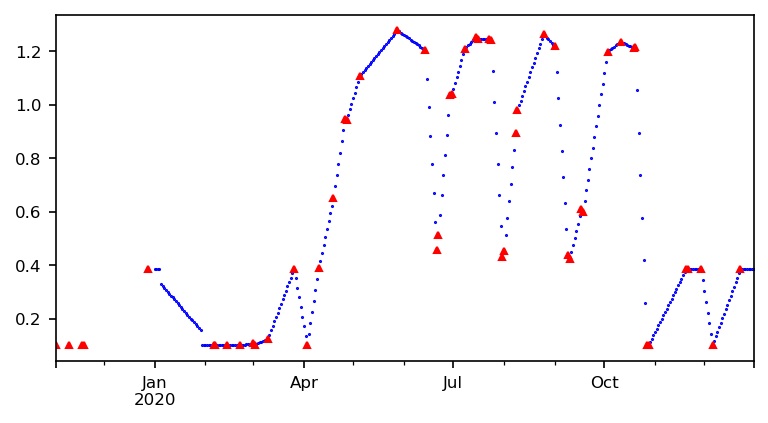

In [379]:
fig, ax0 = plt.subplots(1, 1, figsize=(6, 3), dpi=150)
interp_daily_etf_df['etf'].plot(ax=ax0, linestyle='none', marker='.', ms=1, color='blue')
scene_etf_df['etf'].plot(ax=ax0, linestyle='none', marker='^', ms=3, color='red')

In [380]:
def plot_etf_comparison(all_interp_etf_df, all_scene_etf_df, all_kc_df, year, cell_id, outdir=None, show_plot=True):
    # Filter data for the specified year and cell
    interp_etf_df = all_interp_etf_df[(all_interp_etf_df['scene_year'] == year) & (all_interp_etf_df['cell_id'] == cell_id)]
    scene_etf_df = all_scene_etf_df[(all_scene_etf_df['scene_year'] == year) & (all_scene_etf_df['cell_id'] == cell_id)]
    kc_df = all_kc_df[(all_kc_df['scene_year'] == year) & (all_kc_df['cell_id'] == cell_id)]

    # Get unique crop numbers for the filtered data
    unique_crops = interp_etf_df['crop_num'].unique()

    for crop_num in unique_crops:
        # Filter data for this crop
        crop_interp_df = interp_etf_df[interp_etf_df['crop_num'] == crop_num]
        crop_scene_df = scene_etf_df[scene_etf_df['crop_num'] == crop_num]
        crop_kc_df = kc_df[kc_df['crop_num'] == crop_num]

         # Align the dataframes
        aligned_df = pd.concat([crop_interp_df['etf'], crop_kc_df['kc']], axis=1, join='inner')

        # Create the figure and subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), dpi=150)

        # Plot ETf comparison
        ax1.plot(aligned_df.index, aligned_df['etf'], linestyle='none', marker='.', ms=1, color='blue', alpha=0.5, label='Interpolated ETf')
        ax1.plot(crop_scene_df.index, crop_scene_df['etf'], linestyle='none', marker='^', ms=3, color='red', alpha=0.5, label='Scene ETf')
        ax1.plot(aligned_df.index, aligned_df['kc'], linestyle='-', color='green', alpha=0.5, label='Hypothetical Kc')

        # Set title and labels for ETf comparison plot
        ax1.set_title(f'ETf Comparison for Year {year}, Cell {cell_id} \nCrop {crop_num}: {crop_types[crop_num]}')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('ETf / Kc')
        ax1.set_ylim(0, 1.5)  # Adjust as needed
        ax1.legend()

        # Calculate and plot error
        error = aligned_df['etf'] - aligned_df['kc']
        ax2.plot(aligned_df.index, error, linestyle='-', color='purple', alpha=0.5)
        ax2.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Difference in ETf / Kc')
        ax2.set_ylim(-1, 1)  # Adjust as needed

        plt.tight_layout()

        if show_plot:
            plt.show()

        if outdir is None:
            outdir = os.getcwd()

        # Get the crop name
        crop_name = crop_types[crop_num]

        # Convert spaces to '-' in crop name
        crop_dir = crop_name.replace(' ', '-')

        # Create the full output directory path
        full_outdir = os.path.join(outdir, 'plots', f'{crop_num}_{crop_dir}')

        # Create the directory if it doesn't exist
        os.makedirs(full_outdir, exist_ok=True)

        # Create the filename
        figname = f'ETf_{crop_num}_{cell_id}_{year}_{interp_method}.png'
        outpath = os.path.join(full_outdir, figname)

        # Save the figure
        fig.savefig(outpath, bbox_inches='tight', facecolor='white')
        plt.close(fig)

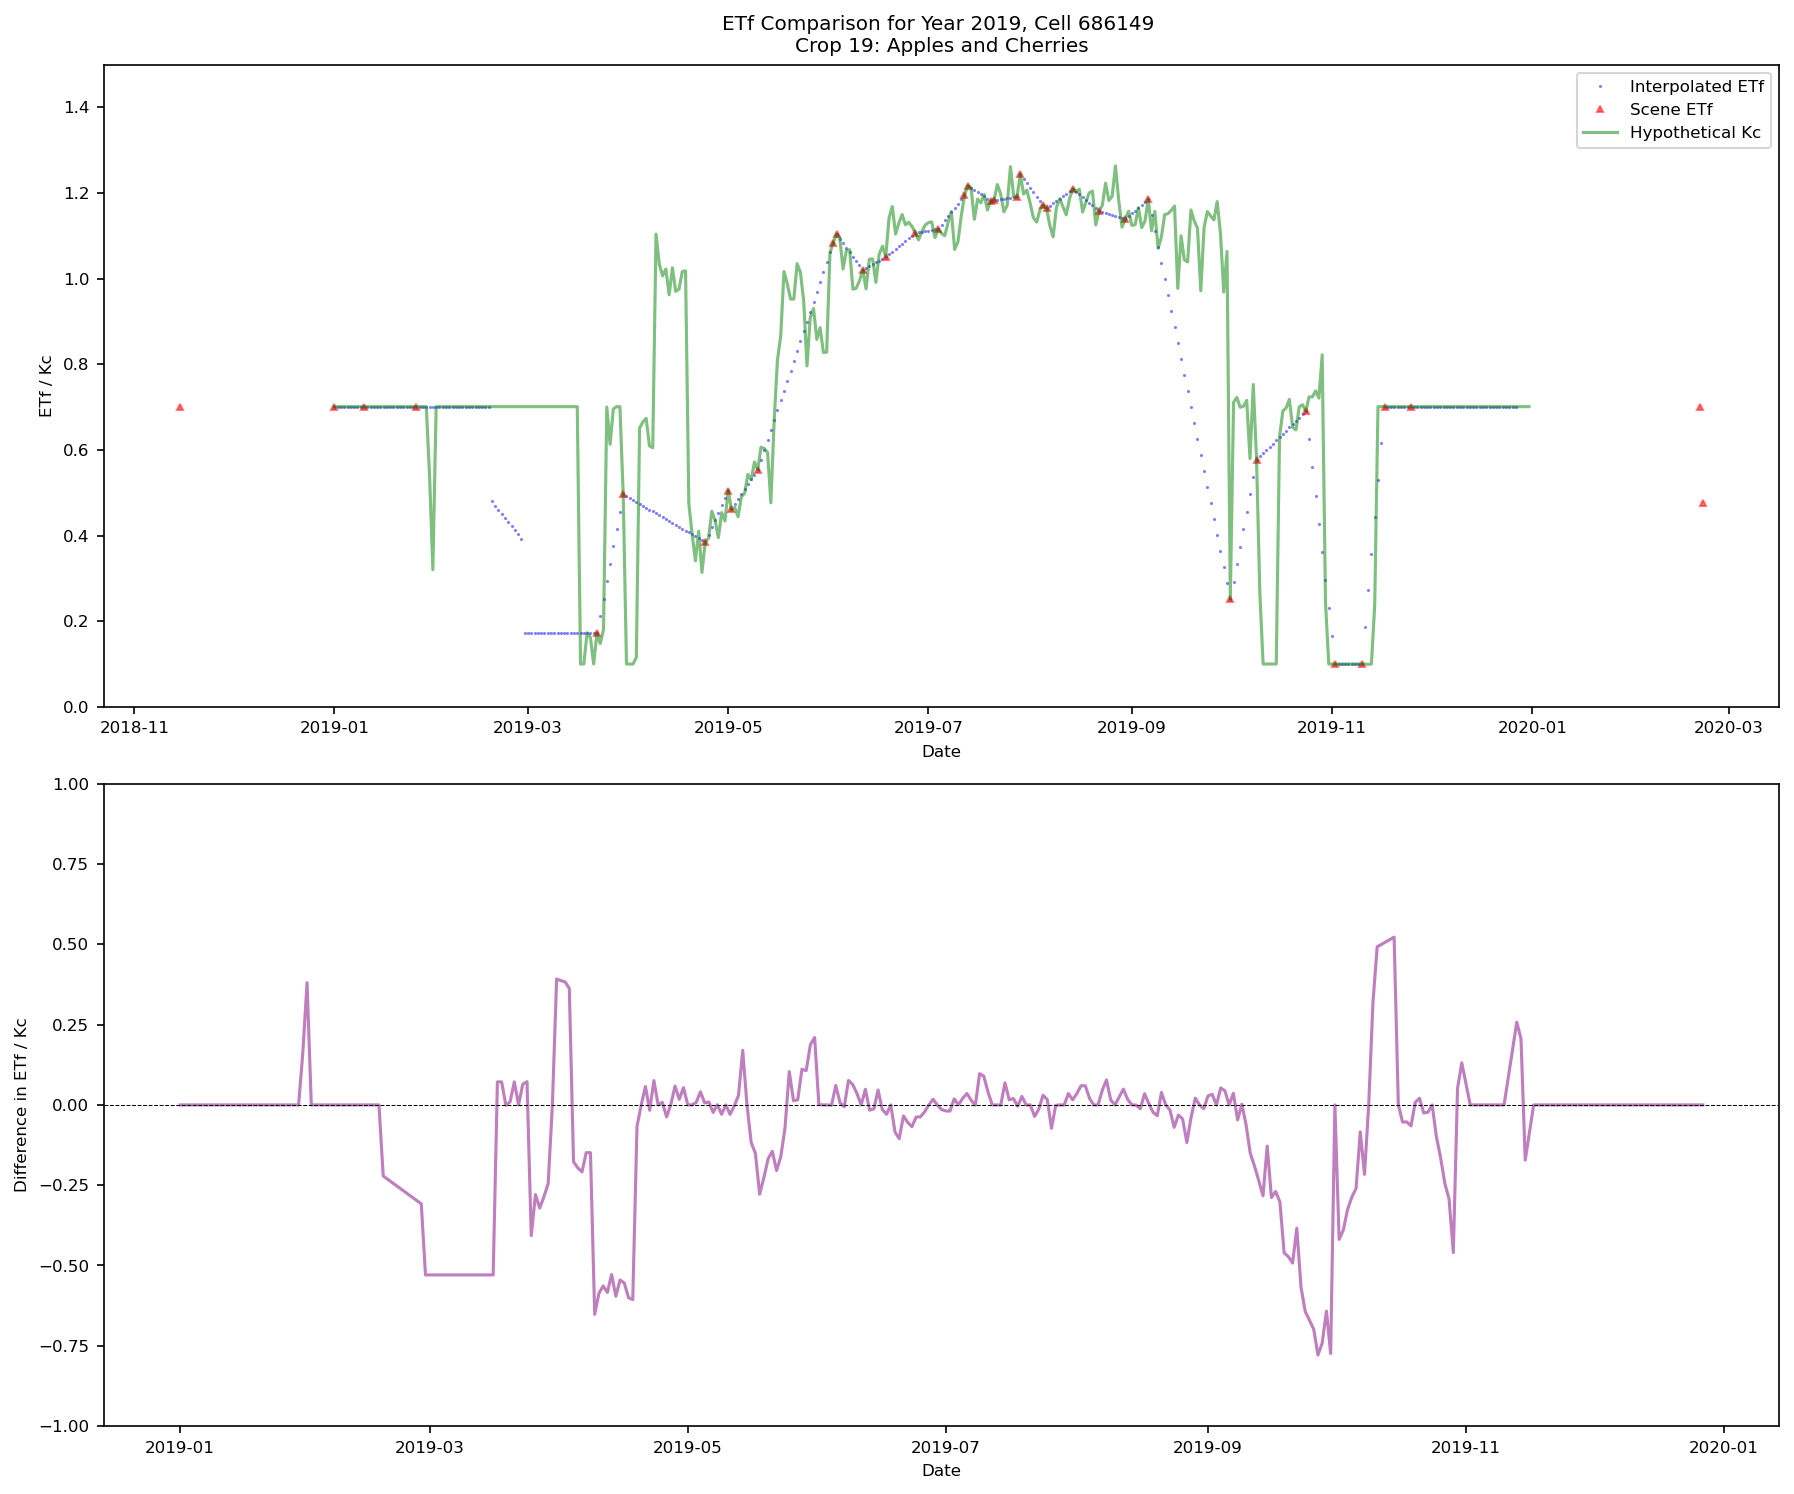

In [381]:
first_cell_id = all_interp_df['cell_id'].unique()[-4]
plot_etf_comparison(all_interp_df, all_scene_df, all_kc_df, year=2019, cell_id=first_cell_id)

In [382]:
cell_ids = all_interp_df['cell_id'].unique()
cell_ids

array([387098, 467476, 473008, 511799, 581084, 605776, 661167, 686149,
       688961, 564161, 565566])

In [383]:
for cell_id in cell_ids:
    plot_etf_comparison(all_interp_df, all_scene_df, all_kc_df, year=2019, cell_id=cell_id, show_plot=False)

# Compute Statistics

In [261]:
stats_str_fmt = '{:6s} {:>20s} {:>20s}'
stats_int_fmt = '{:6s} {:>20d} {:>20d}'
stats_flt_fmt = '{:6s} {:>20.6f} {:>20.6f}'
# stats_header = stats_str_fmt.format('', '2 Landsat Years', '1 Landsat Years')

def print_stats(data_a, data_b, band_1='et_target', band_2='et_interp'):
    # Print comparison statistics of the for two dataframes
    diff_a = data_a[band_1] - data_a[band_2]
    diff_b = data_b[band_1] - data_b[band_2]
    
    # Check if this is the correct calcualtion for computing slope through the origin
    slope_a = (data_a[band_1] * data_a[band_2]).sum() / (data_a[band_2] * data_a[band_2]).sum()
    slope_b = (data_b[band_1] * data_b[band_2]).sum() / (data_b[band_2] * data_b[band_2]).sum()
    r2_a = data_a[[band_1, band_2]].corr()[band_2].values[0]
    r2_b = data_b[[band_1, band_2]].corr()[band_2].values[0]
    rmse_a = (diff_a ** 2).mean() ** 0.5 
    rmse_b = (diff_b ** 2).mean() ** 0.5

    print(stats_int_fmt.format('n:', diff_a.count(), diff_b.count()))
    print(stats_flt_fmt.format('slope:', slope_a, slope_b))
    print(stats_flt_fmt.format('r2:', r2_a, r2_b))
    print(stats_flt_fmt.format('rmse:', rmse_a, rmse_b))
    print(stats_flt_fmt.format('mae:', diff_a.abs().mean(), diff_b.abs().mean()))
    print(stats_flt_fmt.format('mbe:', diff_a.mean(), diff_b.mean()))

monthly_two_landsat_df = monthly_df[monthly_df['scene_year'].isin(two_landsat_years)]
monthly_one_landsat_df = monthly_df[monthly_df['scene_year'].isin(one_landsat_years)]

summer_two_landsat_df = summer_df[summer_df['scene_year'].isin(two_landsat_years)]
summer_one_landsat_df = summer_df[summer_df['scene_year'].isin(one_landsat_years)]
growsn_two_landsat_df = growsn_df[growsn_df['scene_year'].isin(two_landsat_years)]
growsn_one_landsat_df = growsn_df[growsn_df['scene_year'].isin(one_landsat_years)]
annual_two_landsat_df = annual_df[annual_df['scene_year'].isin(two_landsat_years)]
annual_one_landsat_df = annual_df[annual_df['scene_year'].isin(one_landsat_years)]


## Statistics for all monthly data points

The estimates made using 2 Landsats tend to be quite a bit better for all of the metrics

All Data

            2 Landsat Years      1 Landsat Years
n:                     3903                 3457
slope:             1.008683             1.001659
r2:                0.987120             0.972695
rmse:             10.616081            15.241479
mae:               6.732375             9.817403
mbe:               1.932870             2.265358


<Axes: xlabel='et_target', ylabel='et_interp'>

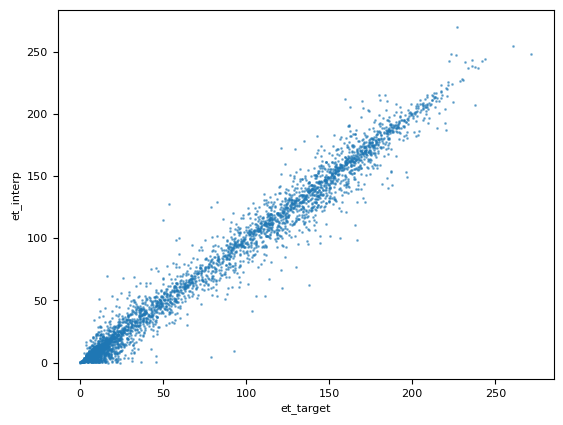

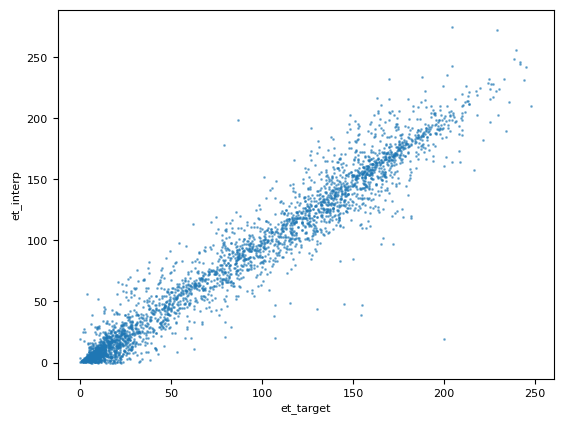

In [263]:
print('All Data\n')
print(stats_str_fmt.format('', '2 Landsat Years', '1 Landsat Years'))
print_stats(monthly_two_landsat_df, monthly_one_landsat_df)
monthly_two_landsat_df.plot.scatter('et_target', 'et_interp', s=1, alpha=0.5)
monthly_one_landsat_df.plot.scatter('et_target', 'et_interp', s=1, alpha=0.5)

## Statistics by scene count in month

Check if limiting the months to only those with some minimum number of scenes would improve the statistics

For the 2 Landsat Years data, the statistics are not greatly impacted or improved by limiting to months with a minimum scene count.
The 1 Landsat Years are greatly improved though, but tend to always have more error even when they are limited to large scene counts (but the comparison may not be totally valid since the data point counts are changing).

In [264]:
print('Scene count >= 0\n')
print(stats_str_fmt.format('', '2 Landsat Years', '1 Landsat Years'))
print_stats(
    monthly_two_landsat_df[monthly_two_landsat_df['scene_count'] >= 0],
    monthly_one_landsat_df[monthly_one_landsat_df['scene_count'] >= 0]
)

Scene count >= 0

            2 Landsat Years      1 Landsat Years
n:                     3903                 3457
slope:             1.008683             1.001659
r2:                0.987120             0.972695
rmse:             10.616081            15.241479
mae:               6.732375             9.817403
mbe:               1.932870             2.265358


In [265]:
print('Scene count >= 1\n')
print(stats_str_fmt.format('', '2 Landsat Years', '1 Landsat Years'))
print_stats(
    monthly_two_landsat_df[monthly_two_landsat_df['scene_count'] >= 1],
    monthly_one_landsat_df[monthly_one_landsat_df['scene_count'] >= 1]
)

Scene count >= 1

            2 Landsat Years      1 Landsat Years
n:                     3669                 3058
slope:             1.008871             1.000755
r2:                0.987351             0.976977
rmse:             10.537961            14.025676
mae:               6.717644             9.267850
mbe:               1.866709             1.967668


In [266]:
print('Scene count >= 2\n')
print(stats_str_fmt.format('', '2 Landsat Years', '1 Landsat Years'))
print_stats(
    monthly_two_landsat_df[monthly_two_landsat_df['scene_count'] >= 2],
    monthly_one_landsat_df[monthly_one_landsat_df['scene_count'] >= 2]
)

Scene count >= 2

            2 Landsat Years      1 Landsat Years
n:                     3131                 2052
slope:             1.011026             1.006982
r2:                0.988481             0.981578
rmse:             10.123242            12.452350
mae:               6.532881             8.418195
mbe:               1.993008             2.223692


In [267]:
print('Scene count >= 3\n')
print(stats_str_fmt.format('', '2 Landsat Years', '1 Landsat Years'))
print_stats(
    monthly_two_landsat_df[monthly_two_landsat_df['scene_count'] >= 3],
    monthly_one_landsat_df[monthly_one_landsat_df['scene_count'] >= 3]
)

Scene count >= 3

            2 Landsat Years      1 Landsat Years
n:                     2496                  918
slope:             1.010418             1.006453
r2:                0.988983             0.985940
rmse:              9.906385            10.610896
mae:               6.412318             7.363183
mbe:               1.925971             1.824270


In [268]:
print('\nStats - scene count >= 4\n')
print(stats_str_fmt.format('', '2 Landsat Years', '1 Landsat Years'))
print_stats(
    monthly_two_landsat_df[monthly_two_landsat_df['scene_count'] >= 4],
    monthly_one_landsat_df[monthly_one_landsat_df['scene_count'] >= 4]
)


Stats - scene count >= 4

            2 Landsat Years      1 Landsat Years
n:                     1733                  205
slope:             1.009300             0.997477
r2:                0.990510             0.985811
rmse:              9.138356             9.013565
mae:               6.073397             6.314376
mbe:               1.899448             0.310821


## Check each scene count separately

Again the 2 Landsat years have lower error than the 1 Landsat years.  
The error decreases as the number of scenes in the month increases for both datasets (if you ignore the low RMSE for count == 0).

In [269]:
print('Scene count == 0\n')
print(stats_str_fmt.format('', '2 Landsat Years', '1 Landsat Years'))
print_stats(
    monthly_two_landsat_df[monthly_two_landsat_df['scene_count'] == 0],
    monthly_one_landsat_df[monthly_one_landsat_df['scene_count'] == 0]
)

Scene count == 0

            2 Landsat Years      1 Landsat Years
n:                      234                  399
slope:             0.979150             1.017767
r2:                0.904588             0.915150
rmse:             11.773390            22.472593
mae:               6.963358            14.029268
mbe:               2.970235             4.546905


In [270]:
print('Scene count == 1\n')
print(stats_str_fmt.format('', '2 Landsat Years', '1 Landsat Years'))
print_stats(
    monthly_two_landsat_df[monthly_two_landsat_df['scene_count'] == 1],
    monthly_one_landsat_df[monthly_one_landsat_df['scene_count'] == 1]
)

Scene count == 1

            2 Landsat Years      1 Landsat Years
n:                      538                 1006
slope:             0.966478             0.977184
r2:                0.961493             0.960473
rmse:             12.685236            16.783715
mae:               7.792906            11.000942
mbe:               1.131684             1.445440


In [271]:
print('Scene count == 2\n')
print(stats_str_fmt.format('', '2 Landsat Years', '1 Landsat Years'))
print_stats(
    monthly_two_landsat_df[monthly_two_landsat_df['scene_count'] == 2],
    monthly_one_landsat_df[monthly_one_landsat_df['scene_count'] == 2]
)

Scene count == 2

            2 Landsat Years      1 Landsat Years
n:                      635                 1134
slope:             1.015839             1.007524
r2:                0.982278             0.977669
rmse:             10.934043            13.763772
mae:               7.006781             9.272253
mbe:               2.256514             2.547033


In [272]:
print('Scene count == 3\n')
print(stats_str_fmt.format('', '2 Landsat Years', '1 Landsat Years'))
print_stats(
    monthly_two_landsat_df[monthly_two_landsat_df['scene_count'] == 3],
    monthly_one_landsat_df[monthly_one_landsat_df['scene_count'] == 3]
)

Scene count == 3

            2 Landsat Years      1 Landsat Years
n:                      763                  713
slope:             1.014351             1.009690
r2:                0.983956             0.985721
rmse:             11.461176            11.027414
mae:               7.182108             7.664734
mbe:               1.986213             2.259413


In [273]:
print('Scene count >= 4\n')
print(stats_str_fmt.format('', '2 Landsat Years', '1 Landsat Years'))
print_stats(
    monthly_two_landsat_df[monthly_two_landsat_df['scene_count'] >= 4],
    monthly_one_landsat_df[monthly_one_landsat_df['scene_count'] >= 4]
)

Scene count >= 4

            2 Landsat Years      1 Landsat Years
n:                     1733                  205
slope:             1.009300             0.997477
r2:                0.990510             0.985811
rmse:              9.138356             9.013565
mae:               6.073397             6.314376
mbe:               1.899448             0.310821


## Compute the stats for the summer months (individually)

In [274]:
print('Summer months (individually)\n')
print(stats_str_fmt.format('', '2 Landsat Years', '1 Landsat Years'))
print_stats(
    monthly_two_landsat_df[monthly_two_landsat_df['month'].isin([6, 7, 8])],
    monthly_one_landsat_df[monthly_one_landsat_df['month'].isin([6, 7, 8])]
)

Summer months (individually)

            2 Landsat Years      1 Landsat Years
n:                     1035                 1016
slope:             1.008135             1.001384
r2:                0.962410             0.896134
rmse:             13.305109            20.890516
mae:               9.343600            14.478293
mbe:               2.448591             2.738252


## Compute stats for the growing season months (individually)

In [275]:
print('Growing season months (individually)\n')
print(stats_str_fmt.format('', '2 Landsat Years', '1 Landsat Years'))
print_stats(
    monthly_two_landsat_df[monthly_two_landsat_df['month'].isin([4, 5, 6, 7, 8, 9, 10])],
    monthly_one_landsat_df[monthly_one_landsat_df['month'].isin([4, 5, 6, 7, 8, 9, 10])]
)

Growing season months (individually)

            2 Landsat Years      1 Landsat Years
n:                     2414                 2365
slope:             1.009758             1.003612
r2:                0.975741             0.952427
rmse:             12.450786            17.402135
mae:               8.297431            11.758751
mbe:               2.347213             2.851296


## Compute the stats for the summer, growing season, and annual totals 

In [276]:
print('Summer total ET\n')
print(stats_str_fmt.format('', '2 Landsat Years', '1 Landsat Years'))
print_stats(summer_two_landsat_df, summer_one_landsat_df)

Summer total ET

            2 Landsat Years      1 Landsat Years
n:                      345                  345
slope:             1.013100             1.012872
r2:                0.980505             0.959815
rmse:             24.986738            35.273433
mae:              19.109182            26.699265
mbe:               7.345773             8.063955


In [277]:
print('Growing season total ET\n')
print(stats_str_fmt.format('', '2 Landsat Years', '1 Landsat Years'))
print_stats(growsn_two_landsat_df, growsn_one_landsat_df)

Growing season total ET

            2 Landsat Years      1 Landsat Years
n:                      345                  345
slope:             1.019075             1.021539
r2:                0.980337             0.969519
rmse:             38.239105            49.649906
mae:              29.675336            39.140890
mbe:              16.423685            19.545841


In [278]:
print('Annual total ET\n')
print(stats_str_fmt.format('', '2 Landsat Years', '1 Landsat Years'))
print_stats(annual_two_landsat_df, annual_one_landsat_df)

Annual total ET

            2 Landsat Years      1 Landsat Years
n:                      345                  345
slope:             1.023991             1.023809
r2:                0.977536             0.966631
rmse:             44.403634            55.205657
mae:              34.815614            44.116979
mbe:              21.866639            22.699546


## Compare to the total ET for the three aggregation time periods to the totals without missing months?

In [25]:
# print('Summer total ET\n')
# print(stats_str_fmt.format('', '2 Landsat Years', '1 Landsat Years'))
# print_stats(summer_two_landsat_df, summer_one_landsat_df, band_1='et_total', band_2='et_interp')

In [26]:
# print('Growing season total ET\n')
# print(stats_str_fmt.format('', '2 Landsat Years', '1 Landsat Years'))
# print_stats(growsn_two_landsat_df, growsn_one_landsat_df, band_1='et_total', band_2='et_interp')

In [27]:
# print('Annual total ET\n')
# print(stats_str_fmt.format('', '2 Landsat Years', '1 Landsat Years'))
# print_stats(annual_two_landsat_df, annual_one_landsat_df, band_1='et_total', band_2='et_interp')